# Premier League Football Data - EDA Part 4

## Advanced Team Statistics Analysis

This notebook explores the detailed team statistics including:
- Shooting statistics (shots, shots on target, conversion rates)
- Passing statistics (pass completion, progressive passes)
- Defensive statistics (tackles, blocks, interceptions)
- Possession statistics
- Correlation analysis between metrics

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['font.size'] = 11

# Data paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'

# Load data
team_stats = pd.read_csv(PROCESSED_DIR / 'all_team_stats.csv')

display(Markdown(f"""
✅ **Data loaded successfully!**

| Metric | Value |
|--------|-------|
| Team Stats Shape | **{team_stats.shape}** |
| Seasons | **{team_stats['season'].unique()}** |
| Teams per season | **~{len(team_stats) // team_stats['season'].nunique()}** |
"""))


✅ **Data loaded successfully!**

| Metric | Value |
|--------|-------|
| Team Stats Shape | **(120, 351)** |
| Seasons | **['2020-2021' '2021-2022' '2022-2023' '2023-2024' '2024-2025' '2025-2026']** |
| Teams per season | **~20** |


In [2]:
# Explore available columns
columns = team_stats.columns.tolist()

# Group columns by type
shooting_cols = [c for c in columns if 'shooting' in c.lower() or 'shot' in c.lower() or 'goals' in c.lower()]
passing_cols = [c for c in columns if 'pass' in c.lower() or 'prog' in c.lower()]
possession_cols = [c for c in columns if 'poss' in c.lower() or 'touch' in c.lower() or 'carry' in c.lower()]
defense_cols = [c for c in columns if 'def' in c.lower() or 'tackle' in c.lower() or 'block' in c.lower() or 'intercept' in c.lower()]
gk_cols = [c for c in columns if 'gk' in c.lower() or 'save' in c.lower() or 'keeper' in c.lower()]

display(Markdown(f"""
**Total columns:** {len(columns)}

## 📋 Column categories found:

| Category | Count |
|----------|-------|
| Shooting related | **{len(shooting_cols)}** columns |
| Passing related | **{len(passing_cols)}** columns |
| Possession related | **{len(possession_cols)}** columns |
| Defense related | **{len(defense_cols)}** columns |
| Goalkeeping related | **{len(gk_cols)}** columns |
"""))


**Total columns:** 351

## 📋 Column categories found:

| Category | Count |
|----------|-------|
| Shooting related | **52** columns |
| Passing related | **58** columns |
| Possession related | **20** columns |
| Defense related | **52** columns |
| Goalkeeping related | **40** columns |


## 1. Identify Key Football Metrics

Focus on the most important metrics for football analytics:
- **Offensive**: Goals, xG, shots, shots on target, shot conversion
- **Defensive**: Goals against, xGA, tackles, blocks, interceptions
- **Possession**: Pass completion, progressive passes, touches in final third

In [3]:
# Identify key football metrics from the columns
columns = team_stats.columns.tolist()

# Find key metric columns using common football stat naming conventions
def find_columns(keywords, cols):
    """Find columns containing any of the keywords."""
    return [c for c in cols if any(kw in c.lower() for kw in keywords)]

# Key football metrics
xg_cols = find_columns(['xg', 'expected'], columns)
goals_cols = find_columns(['goals', 'gls'], columns)
shots_cols = find_columns(['shot', 'sh_', 'sot'], columns)
pass_cols = find_columns(['pass', 'prog'], columns)
poss_cols = find_columns(['poss', 'touch'], columns)
tackle_cols = find_columns(['tackle', 'tkl'], columns)
aerial_cols = find_columns(['aerial', 'won'], columns)

# Build sample columns display
sample_display = ""
for name, cols in [('xG', xg_cols), ('Shots', shots_cols), ('Passing', pass_cols)]:
    if cols:
        sample_display += f"- **{name}:** `{', '.join(cols[:5])}`\n"

display(Markdown(f"""
## 📊 KEY FOOTBALL METRICS IDENTIFIED

| Category | Count |
|----------|-------|
| xG-related | **{len(xg_cols)}** columns |
| Goals-related | **{len(goals_cols)}** columns |
| Shots-related | **{len(shots_cols)}** columns |
| Passing-related | **{len(pass_cols)}** columns |
| Possession-related | **{len(poss_cols)}** columns |
| Tackling-related | **{len(tackle_cols)}** columns |

---

### 🔍 Sample columns by category:

{sample_display}
"""))


## 📊 KEY FOOTBALL METRICS IDENTIFIED

| Category | Count |
|----------|-------|
| xG-related | **32** columns |
| Goals-related | **26** columns |
| Shots-related | **30** columns |
| Passing-related | **58** columns |
| Possession-related | **20** columns |
| Tackling-related | **22** columns |

---

### 🔍 Sample columns by category:

- **xG:** `std_f_xg, std_f_npxg, std_f_xg_assist, std_f_npxg_xg_assist, std_f_xg_per90`
- **Shots:** `sht_f_shots, sht_f_shots_on_target, sht_f_shots_on_target_pct, sht_f_shots_per90, sht_f_shots_on_target_per90`
- **Passing:** `std_f_progressive_carries, std_f_progressive_passes, std_a_progressive_carries, std_a_progressive_passes, pas_f_passes_completed`



## 3. Title Contenders vs Relegation Candidates

Compare statistical profiles of top teams vs bottom teams to identify key differentiators.

In [4]:
# Load fixtures to identify top/bottom teams by points
fixtures = pd.read_csv(PROCESSED_DIR / 'all_fixtures.csv')

# Get numeric columns for analysis
numeric_cols = team_stats.select_dtypes(include=[np.number]).columns.tolist()

# Separate 'for' (attacking) and 'against' (defensive) columns
for_cols = [c for c in numeric_cols if '_for' in c.lower()]
against_cols = [c for c in numeric_cols if '_against' in c.lower()]

display(Markdown(f"""
**Offensive metrics ('for'):** {len(for_cols)} columns

**Defensive metrics ('against'):** {len(against_cols)} columns
"""))

# Calculate points per team per season
def get_team_points(fixtures_df):
    """Calculate league standings based on fixtures."""
    results = []
    
    for season in fixtures_df['season'].unique():
        season_data = fixtures_df[fixtures_df['season'] == season]
        
        # Home points
        home = season_data.groupby('home_team').agg({
            'match_result': lambda x: (x == 2).sum() * 3 + (x == 1).sum()
        }).reset_index()
        home.columns = ['team', 'home_points']
        
        # Away points  
        away = season_data.groupby('away_team').agg({
            'match_result': lambda x: (x == 0).sum() * 3 + (x == 1).sum()
        }).reset_index()
        away.columns = ['team', 'away_points']
        
        # Combine
        standings = home.merge(away, on='team', how='outer').fillna(0)
        standings['points'] = standings['home_points'] + standings['away_points']
        standings['season'] = season
        results.append(standings)
    
    return pd.concat(results, ignore_index=True)

standings = get_team_points(fixtures)
standings_merged = team_stats.merge(standings[['team', 'season', 'points']], on=['team', 'season'], how='left')

# Identify top 4 and bottom 3 teams per season
standings_merged['position_tier'] = standings_merged.groupby('season')['points'].transform(
    lambda x: pd.cut(x.rank(ascending=False), bins=[0, 4, 17, 20], labels=['Top 4', 'Mid-table', 'Relegation'])
)

display(Markdown("## 📊 Team Distribution by Position Tier"))
display(standings_merged['position_tier'].value_counts().to_frame("Count"))


**Offensive metrics ('for'):** 0 columns

**Defensive metrics ('against'):** 6 columns


## 📊 Team Distribution by Position Tier

,Count
position_tier,
Mid-table,78
Top 4,24
Relegation,18


## 4. Compare Top 4 vs Relegation Teams

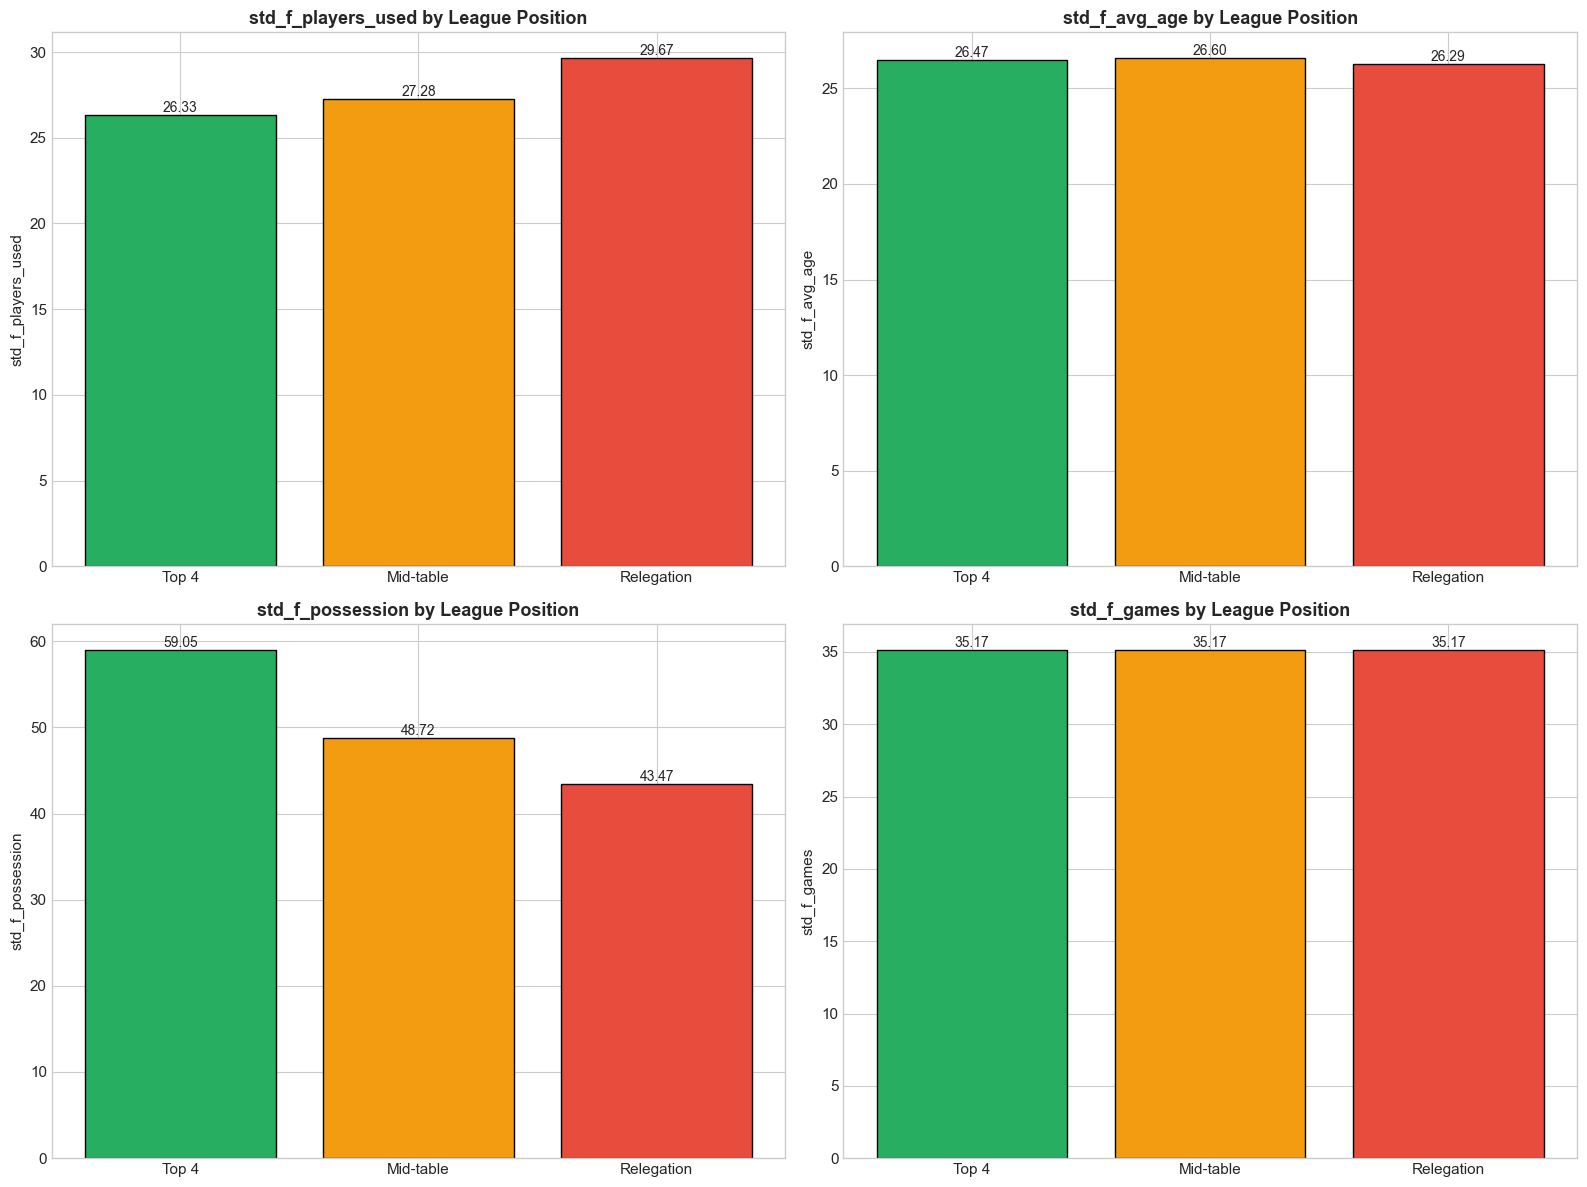

## 🔍 Key Insight: What separates Top 4 from Relegation candidates?

In [5]:
# Compare key metrics between Top 4 and Relegation teams
numeric_cols = [c for c in numeric_cols if c not in ['points']]

# Group by position tier and compare means
tier_comparison = standings_merged.groupby('position_tier')[numeric_cols[:20]].mean()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Select 4 meaningful comparison metrics (first 4 numeric columns as proxy)
comparison_cols = numeric_cols[:4]

for idx, col in enumerate(comparison_cols):
    ax = axes[idx // 2, idx % 2]
    tier_means = standings_merged.groupby('position_tier')[col].mean().sort_index()
    
    colors = ['#27ae60', '#f39c12', '#e74c3c']  # Green, Yellow, Red for Top, Mid, Bottom
    bars = ax.bar(tier_means.index, tier_means.values, color=colors, edgecolor='black')
    ax.set_ylabel(col, fontsize=11)
    ax.set_title(f'{col} by League Position', fontsize=13, fontweight='bold')
    
    # Add value labels
    for bar, val in zip(bars, tier_means.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.2f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../notebooks/figures/tier_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

display(Markdown("## 🔍 Key Insight: What separates Top 4 from Relegation candidates?"))

## 5. Points Correlation Analysis

Identify which metrics most strongly predict league success (points).

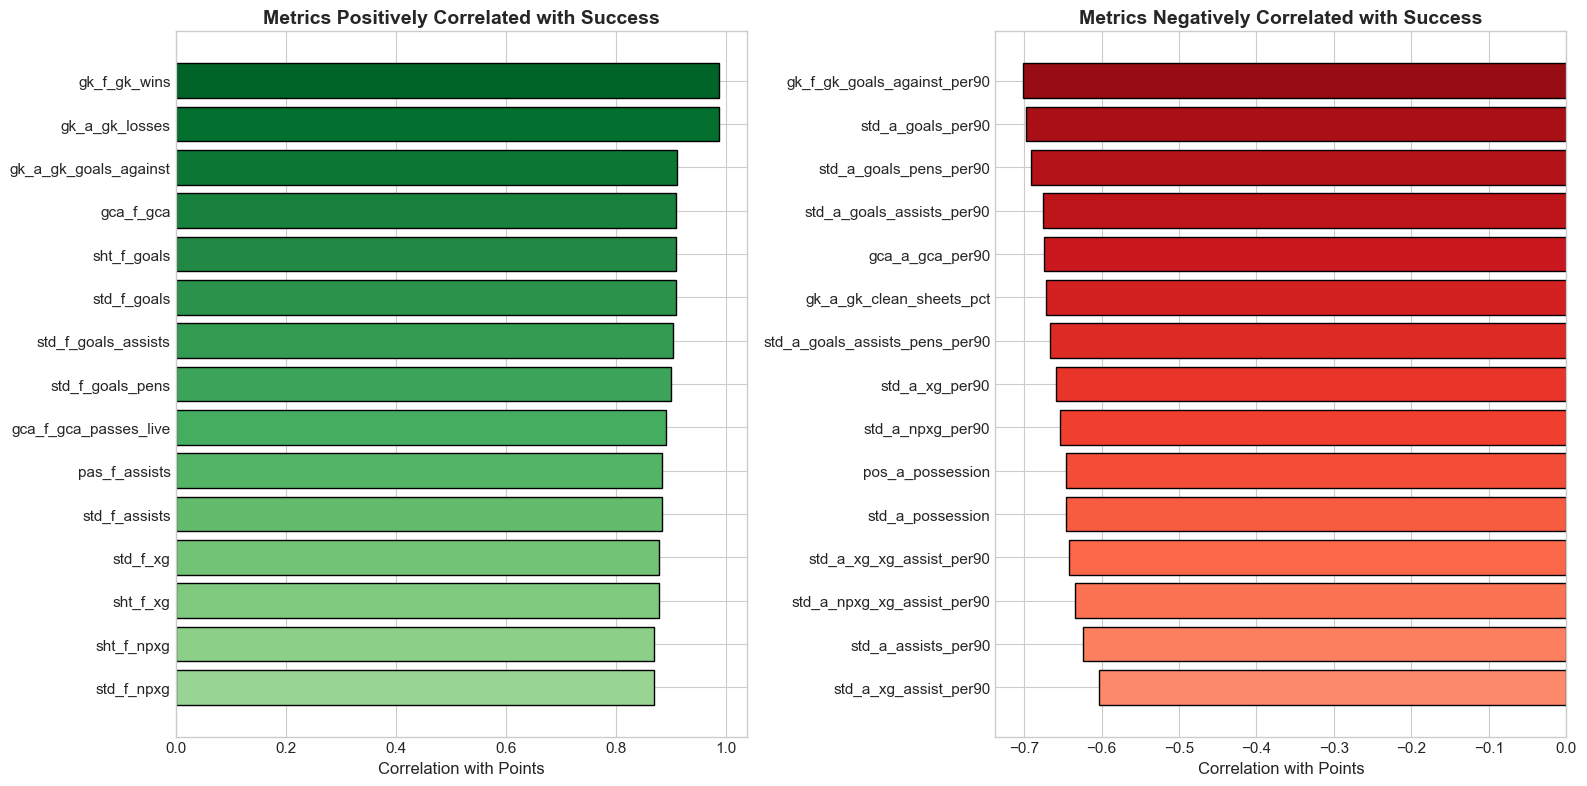


## 🏆 TOP 10 SUCCESS PREDICTORS (Positive Correlation)

- **gk_f_gk_wins:** 0.989
- **gk_a_gk_losses:** 0.989
- **gk_a_gk_goals_against:** 0.912
- **gca_f_gca:** 0.910
- **sht_f_goals:** 0.909
- **std_f_goals:** 0.909
- **std_f_goals_assists:** 0.905
- **std_f_goals_pens:** 0.902
- **gca_f_gca_passes_live:** 0.891
- **pas_f_assists:** 0.884


In [6]:
# Find metrics most correlated with points (league success)
analysis_cols = [c for c in numeric_cols if c not in ['points']]

correlations_with_points = {}
for col in analysis_cols:
    if standings_merged[col].notna().sum() > 10:  # Need enough data
        corr = standings_merged['points'].corr(standings_merged[col])
        if not np.isnan(corr):
            correlations_with_points[col] = corr

# Sort by absolute correlation
corr_df = pd.DataFrame.from_dict(correlations_with_points, orient='index', columns=['correlation'])
corr_df['abs_corr'] = corr_df['correlation'].abs()
corr_df = corr_df.sort_values('abs_corr', ascending=False)

# Plot top correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top positive correlations (what helps win)
top_positive = corr_df[corr_df['correlation'] > 0].head(15)
colors_pos = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_positive)))
axes[0].barh(top_positive.index, top_positive['correlation'], color=colors_pos[::-1], edgecolor='black')
axes[0].set_xlabel('Correlation with Points', fontsize=12)
axes[0].set_title('Metrics Positively Correlated with Success', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Top negative correlations (what hurts)
top_negative = corr_df[corr_df['correlation'] < 0].head(15)
colors_neg = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_negative)))
axes[1].barh(top_negative.index, top_negative['correlation'], color=colors_neg[::-1], edgecolor='black')
axes[1].set_xlabel('Correlation with Points', fontsize=12)
axes[1].set_title('Metrics Negatively Correlated with Success', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../notebooks/figures/success_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

# Build success predictors list
predictors_list = "\n".join([f"- **{col}:** {row['correlation']:.3f}" for col, row in top_positive.head(10).iterrows()])
display(Markdown(f"""
## 🏆 TOP 10 SUCCESS PREDICTORS (Positive Correlation)

{predictors_list}
"""))

## 6. Team Playing Style Clustering

Cluster teams by their playing style to identify tactical patterns.

## 7. Playing Style Visualization

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Use metrics correlated with success for clustering
top_metrics = corr_df.head(30).index.tolist()
cluster_data = standings_merged[top_metrics].dropna(axis=1)

if len(cluster_data.columns) >= 5:
    # Standardize
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)
    
    # PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    
    # K-Means clustering (4 groups: elite, contenders, mid-table, strugglers)
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_data)
    
    # Add to dataframe
    standings_merged['cluster'] = clusters
    standings_merged['pca1'] = pca_result[:, 0]
    standings_merged['pca2'] = pca_result[:, 1]
    
    display(Markdown(f"""
✅ **PCA Analysis Complete**

| Component | Explained Variance |
|-----------|-------------------|
| Total | **{pca.explained_variance_ratio_.sum()*100:.1f}%** |
| Component 1 | **{pca.explained_variance_ratio_[0]*100:.1f}%** |
| Component 2 | **{pca.explained_variance_ratio_[1]*100:.1f}%** |
"""))
else:
    display(Markdown("⚠️ **Not enough valid columns for clustering**"))


✅ **PCA Analysis Complete**

| Component | Explained Variance |
|-----------|-------------------|
| Total | **93.9%** |
| Component 1 | **90.1%** |
| Component 2 | **3.8%** |


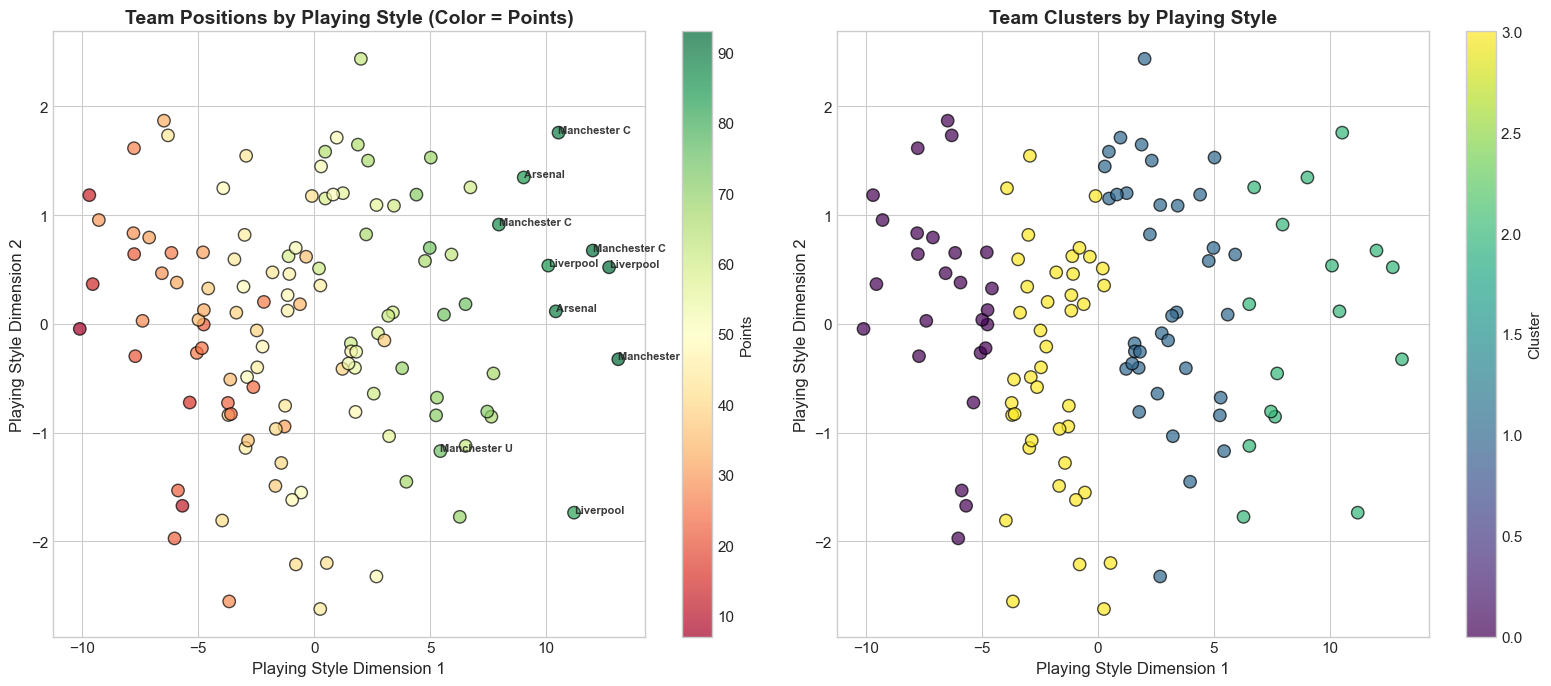


📊 CLUSTER ANALYSIS:


,Avg Points,Min Points,Max Points,Count
cluster,,,,
0,25.7,7,43,26
1,59.8,38,75,37
2,78.7,60,93,16
3,41.6,23,61,41


In [8]:
# Visualize playing style clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA scatter colored by points (actual performance)
scatter1 = axes[0].scatter(standings_merged['pca1'], standings_merged['pca2'], 
                           c=standings_merged['points'], cmap='RdYlGn', 
                           alpha=0.7, s=80, edgecolors='black')
axes[0].set_xlabel('Playing Style Dimension 1', fontsize=12)
axes[0].set_ylabel('Playing Style Dimension 2', fontsize=12)
axes[0].set_title('Team Positions by Playing Style (Color = Points)', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Points')

# Annotate elite teams
elite_teams = standings_merged.nlargest(10, 'points')
for _, row in elite_teams.iterrows():
    axes[0].annotate(f"{row['team'][:12]}", (row['pca1'], row['pca2']), 
                     fontsize=8, alpha=0.9, fontweight='bold')

# PCA scatter colored by cluster
scatter2 = axes[1].scatter(standings_merged['pca1'], standings_merged['pca2'], 
                           c=standings_merged['cluster'], cmap='viridis', 
                           alpha=0.7, s=80, edgecolors='black')
axes[1].set_xlabel('Playing Style Dimension 1', fontsize=12)
axes[1].set_ylabel('Playing Style Dimension 2', fontsize=12)
axes[1].set_title('Team Clusters by Playing Style', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.savefig('../notebooks/figures/playing_style_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

# Analyze cluster characteristics
print("\n📊 CLUSTER ANALYSIS:")
cluster_points = standings_merged.groupby('cluster')['points'].agg(['mean', 'min', 'max', 'count'])
cluster_points.columns = ['Avg Points', 'Min Points', 'Max Points', 'Count']
display(cluster_points.round(1))

## 8. Key Insights Summary

In [9]:
# Build top predictors list
top_predictors = "\n".join([f"- **{col}:** r={row['correlation']:.3f} ({'↑ higher is better' if row['correlation'] > 0 else '↓ lower is better'})" 
                           for col, row in corr_df.head(5).iterrows()])

display(Markdown(f"""
# 📊 KEY INSIGHTS - ADVANCED TEAM STATISTICS

---

## 📈 DATA OVERVIEW

| Metric | Value |
|--------|-------|
| Total Team-Seasons Analyzed | **{len(team_stats)}** |
| Unique Teams | **{team_stats['team'].nunique()}** |
| Seasons Covered | **{team_stats['season'].nunique()}** |
| Statistics Tracked | **{len(numeric_cols)}** metrics |

---

## 🏆 SUCCESS PREDICTORS

Top metrics correlated with league success (points):

{top_predictors}

---

## 🔍 PLAYING STYLE CLUSTERS

- Teams naturally group into **{standings_merged['cluster'].nunique()}** distinct playing styles
- PCA captures **{pca.explained_variance_ratio_.sum()*100:.1f}%** of tactical variance

---

## 💡 KEY TAKEAWAYS FOR ML

1. Use top-correlated metrics as primary features
2. Consider cluster membership as a categorical feature
3. Separate 'for' and 'against' metrics for attack/defense modeling
4. Playing style (PCA components) can help predict match outcomes
"""))


# 📊 KEY INSIGHTS - ADVANCED TEAM STATISTICS

---

## 📈 DATA OVERVIEW

| Metric | Value |
|--------|-------|
| Total Team-Seasons Analyzed | **120** |
| Unique Teams | **28** |
| Seasons Covered | **6** |
| Statistics Tracked | **348** metrics |

---

## 🏆 SUCCESS PREDICTORS

Top metrics correlated with league success (points):

- **gk_f_gk_wins:** r=0.989 (↑ higher is better)
- **gk_a_gk_losses:** r=0.989 (↑ higher is better)
- **gk_a_gk_goals_against:** r=0.912 (↑ higher is better)
- **gca_f_gca:** r=0.910 (↑ higher is better)
- **sht_f_goals:** r=0.909 (↑ higher is better)

---

## 🔍 PLAYING STYLE CLUSTERS

- Teams naturally group into **4** distinct playing styles
- PCA captures **93.9%** of tactical variance

---

## 💡 KEY TAKEAWAYS FOR ML

1. Use top-correlated metrics as primary features
2. Consider cluster membership as a categorical feature
3. Separate 'for' and 'against' metrics for attack/defense modeling
4. Playing style (PCA components) can help predict match outcomes
